In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Taille train complète : 5728
Taille val complète   : 448

Distribution des classes (train subset) :
label
0     388
1     140
2     262
3     667
4     294
5     159
6     160
7     556
8     179
9     477
10    305
11    159
12    213
13    363
14    320
15     97
16    402
17    198
18    308
19     81
Name: count, dtype: int64

Distribution des classes (val subset) :
label
0     18
1     15
2     23
3     66
4     20
5     12
6     15
7     38
8     10
9     43
10    22
11    16
12    19
13    25
14    25
15     7
16    28
17    20
18    16
19    10
Name: count, dtype: int64


/tmp/ipython-input-2478379781.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, palette="viridis")
/tmp/ipython-input-2478379781.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, palette="magma")


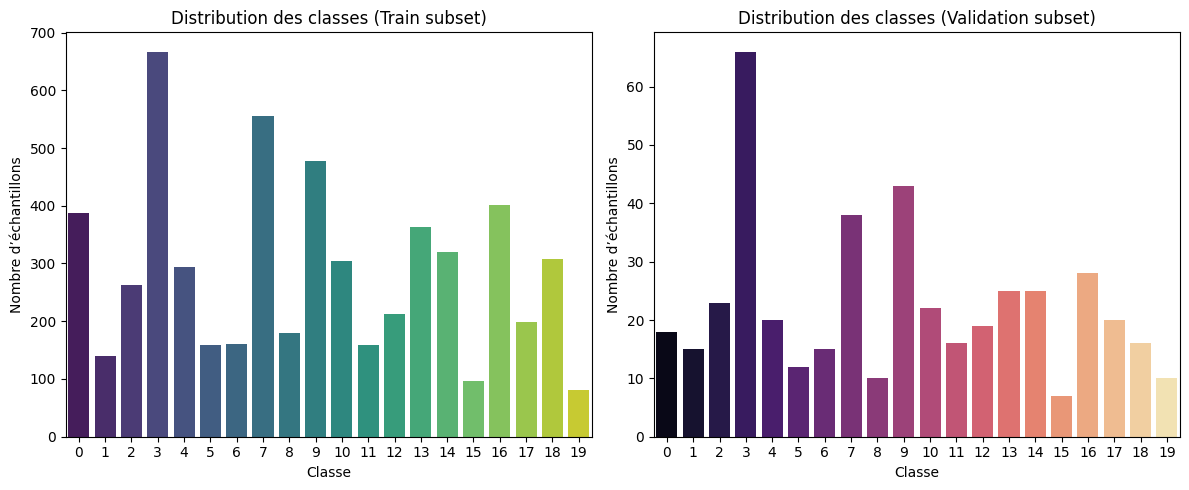

In [ ]:
# =========================
# ÉTAPE 1 — Seed + sous-échantillon + visualisation classes
# =========================

import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fixer le seed (recommandation du prof)
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

# 2. Chemins de tes données
base_audio_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/train_val_videos/TrainValAudio"
train_csv = "/content/drive/MyDrive/Projet non-alternant/Corpus/csv/train_audio_labels.csv"
val_csv   = "/content/drive/MyDrive/Projet non-alternant/Corpus/csv/val_audio_labels.csv"

# 3. Charger les CSV complets
full_train_df = pd.read_csv(train_csv)
full_val_df   = pd.read_csv(val_csv)

# 4. Ajouter les chemins vers les fichiers audio
full_train_df["filepath"] = full_train_df["video_id"].apply(
    lambda x: os.path.join(base_audio_dir, f"{x}.wav")
)
full_val_df["filepath"] = full_val_df["video_id"].apply(
    lambda x: os.path.join(base_audio_dir, f"{x}.wav")
)

print("Taille train complète :", len(full_train_df))
print("Taille val complète   :", len(full_val_df))

# 5. Sous-échantillonnage (modifiable selon ta RAM)
"""train_frac = 0.35
val_frac   = 0.30

train_df = full_train_df.sample(frac=train_frac, random_state=42).reset_index(drop=True)
val_df   = full_val_df.sample(frac=val_frac,   random_state=42).reset_index(drop=True)

print("Taille train subset :", len(train_df))
print("Taille val subset   :", len(val_df))"""

# 6. Comptage par classe
train_counts = full_train_df["label"].value_counts().sort_index()
val_counts   = full_val_df["label"].value_counts().sort_index()

print("\nDistribution des classes (train subset) :")
print(train_counts)
print("\nDistribution des classes (val subset) :")
print(val_counts)

# 7. 🔥 Visualisation des distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=train_counts.index, y=train_counts.values, palette="viridis")
plt.title("Distribution des classes (Train subset)")
plt.xlabel("Classe")
plt.ylabel("Nombre d’échantillons")

plt.subplot(1, 2, 2)
sns.barplot(x=val_counts.index, y=val_counts.values, palette="magma")
plt.title("Distribution des classes (Validation subset)")
plt.xlabel("Classe")
plt.ylabel("Nombre d’échantillons")

plt.tight_layout()
plt.show()


Nombre total de classes : 20

Poids calculés pour chaque classe :
Classe 0: 0.5481
Classe 1: 1.5191
Classe 2: 0.8117
Classe 3: 0.3189
Classe 4: 0.7234
Classe 5: 1.3376
Classe 6: 1.3292
Classe 7: 0.3825
Classe 8: 1.1881
Classe 9: 0.4459
Classe 10: 0.6973
Classe 11: 1.3376
Classe 12: 0.9985
Classe 13: 0.5859
Classe 14: 0.6646
Classe 15: 2.1925
Classe 16: 0.5290
Classe 17: 1.0741
Classe 18: 0.6905
Classe 19: 2.6256


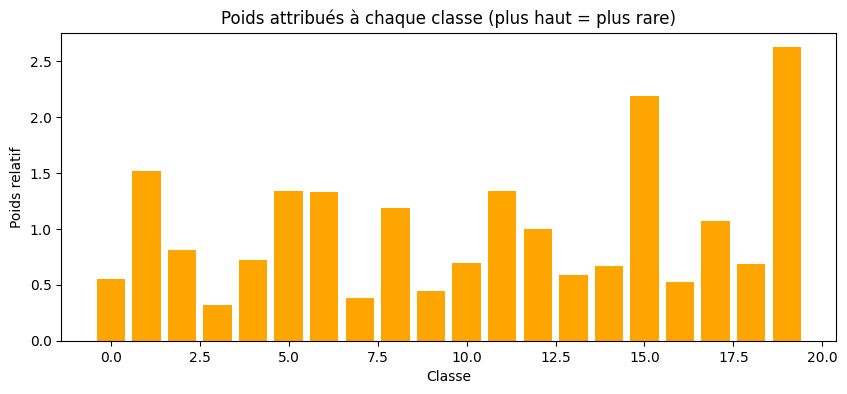

In [ ]:
# =========================
# ÉTAPE 2 — Calcul et visualisation des poids de classes
# =========================

import torch
import matplotlib.pyplot as plt

# 1️⃣ Récupérer le nombre d'exemples par classe
class_counts = full_train_df["label"].value_counts().sort_index()
num_classes = len(class_counts)
print(f"Nombre total de classes : {num_classes}")

# 2️⃣ Calculer les poids inverses de fréquence
#    (plus une classe est rare -> plus son poids est élevé)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * num_classes  # normalisation
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

print("\nPoids calculés pour chaque classe :")
for i, w in enumerate(class_weights_tensor):
    print(f"Classe {i}: {w:.4f}")

# 3️⃣ Visualiser ces poids
plt.figure(figsize=(10,4))
plt.bar(range(num_classes), class_weights_tensor.numpy(), color='orange')
plt.title("Poids attribués à chaque classe (plus haut = plus rare)")
plt.xlabel("Classe")
plt.ylabel("Poids relatif")
plt.show()

# ✅ Maintenant on a un tenseur prêt à passer à CrossEntropyLoss :
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))


In [ ]:
!pip uninstall -y panns-inference
!pip install git+https://github.com/qiuqiangkong/panns_inference.git

  Cloning https://github.com/qiuqiangkong/panns_inference.git to /tmp/pip-req-build-57geb130
  Running command git clone --filter=blob:none --quiet https://github.com/qiuqiangkong/panns_inference.git /tmp/pip-req-build-57geb130
  Resolved https://github.com/qiuqiangkong/panns_inference.git to commit f673f604ec6f4805a61c5b3be087e24776ec5fda
  Preparing metadata (setup.py) ... done
  Created wheel for panns-inference: filename=panns_inference-0.1.1-py3-none-any.whl size=8266 sha256=ce2c37366323b8d14d5298e3ea403c0415dea9a360238ee68115260c923eee05
  Stored in directory: /tmp/pip-ephem-wheel-cache-fxh4kx1w/wheels/5c/08/31/c5c15dc831124f27580b43c2940c6bfd9d9b789e175047d7c4
Successfully built panns-inference


In [ ]:
from panns_inference.models import Cnn14

model = Cnn14(sample_rate=16000, window_size=1024, hop_size=320, mel_bins=64, fmin=50, fmax=8000, classes_num=527)
print("✅ Import réussi !")
print(model.__class__.__name__, "chargé avec succès.")

✅ Import réussi !
Cnn14 chargé avec succès.


In [ ]:
# =========================
# ÉTAPE 3 — Dataset + DataLoader + Modèle PANNs + Loss pondérée
# =========================

import torchaudio
from torch.utils.data import Dataset, DataLoader
from panns_inference.models import Cnn14
import torch.nn as nn

# ---- 1️⃣ Dataset personnalisé ----
class AudioDataset(Dataset):
    def __init__(self, df, target_sr=16000, duration=10.0):
        self.df = df.reset_index(drop=True)
        self.target_sr = target_sr
        self.max_length = int(target_sr * duration)
        self.resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=target_sr)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row["filepath"]
        label = int(row["label"])

        # Après avoir chargé l’audio :
        waveform, sr = torchaudio.load(filepath)

        # Si stéréo → convertir en mono
        if waveform.shape[0] > 1:
          waveform = waveform.mean(dim=0, keepdim=True)


        # Si audio trop court -> padding, sinon truncation
        if waveform.shape[1] < self.max_length:
            pad = self.max_length - waveform.shape[1]
            waveform = nn.functional.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_length]

        return waveform, label


# ---- 2️⃣ DataLoaders ----
batch_size = 16

train_dataset = AudioDataset(full_train_df)
val_dataset   = AudioDataset(full_val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ---- 3️⃣ Charger Cnn14 préentraîné et adapter à 20 classes ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device :", device)

# ⭐ Paramètres conformes au checkpoint officiel (corrige le mismatch)
pretrained_model = Cnn14(
    sample_rate=16000,
    window_size=512,      # ✅ au lieu de 1024
    hop_size=160,         # ✅ au lieu de 320
    mel_bins=64,
    fmin=50, fmax=8000,
    classes_num=527
)
checkpoint_path = "/content/drive/MyDrive/Projet non-alternant/Audio/PANNs/Cnn14_16k_mAP=0.438 (1).pth"

# Charger les poids du checkpoint officiel
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)


# ⭐ Charger les poids avec strict=False (tolère la tête différente)
pretrained_model.load_state_dict(checkpoint["model"], strict=False)

# ⭐ Adapter la tête de classification à tes 20 classes
# --- AJOUT DU DROPOUT ---
pretrained_model.fc_audioset = nn.Sequential(       # 🔧 nouvelle tête avec dropout
    nn.Dropout(p=0.3),                              # 👈 ajouté : dropout à 30%
    nn.Linear(2048, 20)
)
# --- fin ajout ---


# ⭐ Adapter la tête de classification à tes 20 classes
pretrained_model.fc_audioset = nn.Linear(2048, 20)

model = pretrained_model.to(device)
model.train()


# ---- 4️⃣ Définir la loss pondérée ----
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# ---- 5️⃣ Optimizer ----
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-5,
    weight_decay=1e-4     # 👈 ajouté : régularisation L2
)

print("\n✅ Modèle prêt pour l'entraînement pondéré sur sous-échantillon !")
print("\n✅ Modèle PANNs (Cnn14) chargé et adapté à 20 classes.")
print("Batch example shape:", next(iter(train_loader))[0].shape)


✅ Device : cuda

✅ Modèle prêt pour l'entraînement pondéré sur sous-échantillon !

✅ Modèle PANNs (Cnn14) chargé et adapté à 20 classes.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Batch example shape: torch.Size([16, 1, 160000])


🚀 Démarrage de l'entraînement sur 50 époques...



Epoch 1/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 1/50
Train Loss: 2.9964 | Train Acc: 0.0632
Val Loss:   2.9939 | Val Acc:   0.0692
🔁 Learning rate actuel : 1.00e-05
✅ Nouveau meilleur modèle sauvegardé : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/best_panns_subset.pt (Val Acc = 0.0692)


Epoch 2/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 2/50
Train Loss: 2.9905 | Train Acc: 0.0883
Val Loss:   2.9903 | Val Acc:   0.0938
🔁 Learning rate actuel : 1.00e-05
✅ Nouveau meilleur modèle sauvegardé : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/best_panns_subset.pt (Val Acc = 0.0938)


Epoch 3/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 3/50
Train Loss: 2.9857 | Train Acc: 0.1212
Val Loss:   2.9862 | Val Acc:   0.1317
🔁 Learning rate actuel : 1.00e-05
✅ Nouveau meilleur modèle sauvegardé : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/best_panns_subset.pt (Val Acc = 0.1317)


Epoch 4/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 4/50
Train Loss: 2.9795 | Train Acc: 0.1414
Val Loss:   2.9811 | Val Acc:   0.1429
🔁 Learning rate actuel : 1.00e-05
✅ Nouveau meilleur modèle sauvegardé : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/best_panns_subset.pt (Val Acc = 0.1429)


Epoch 5/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 5/50
Train Loss: 2.9703 | Train Acc: 0.1679
Val Loss:   2.9743 | Val Acc:   0.1696
🔁 Learning rate actuel : 1.00e-05
✅ Nouveau meilleur modèle sauvegardé : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/best_panns_subset.pt (Val Acc = 0.1696)


Epoch 6/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 6/50
Train Loss: 2.9595 | Train Acc: 0.1838
Val Loss:   2.9637 | Val Acc:   0.1562
🔁 Learning rate actuel : 1.00e-05
⚠️ Aucune amélioration (1/5)


Epoch 7/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 7/50
Train Loss: 2.9429 | Train Acc: 0.1920
Val Loss:   2.9491 | Val Acc:   0.1696
🔁 Learning rate actuel : 1.00e-05
⚠️ Aucune amélioration (2/5)


Epoch 8/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 8/50
Train Loss: 2.9214 | Train Acc: 0.2039
Val Loss:   2.9292 | Val Acc:   0.1652
🔁 Learning rate actuel : 1.00e-05
⚠️ Aucune amélioration (3/5)


Epoch 9/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 9/50
Train Loss: 2.9026 | Train Acc: 0.2111
Val Loss:   2.9158 | Val Acc:   0.1652
🔁 Learning rate actuel : 5.00e-06
⚠️ Aucune amélioration (4/5)


Epoch 10/50:   0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 10/50
Train Loss: 2.8903 | Train Acc: 0.2156
Val Loss:   2.9016 | Val Acc:   0.1607
🔁 Learning rate actuel : 5.00e-06
⚠️ Aucune amélioration (5/5)
⏹ Early stopping déclenché !
↘️ Learning rate ajusté à : 5.00e-06

🏁 Entraînement terminé. Meilleure Val Acc : 0.1696 (atteinte à l’époque 5)
🖼️ Courbes enregistrées dans : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/training_curves.png


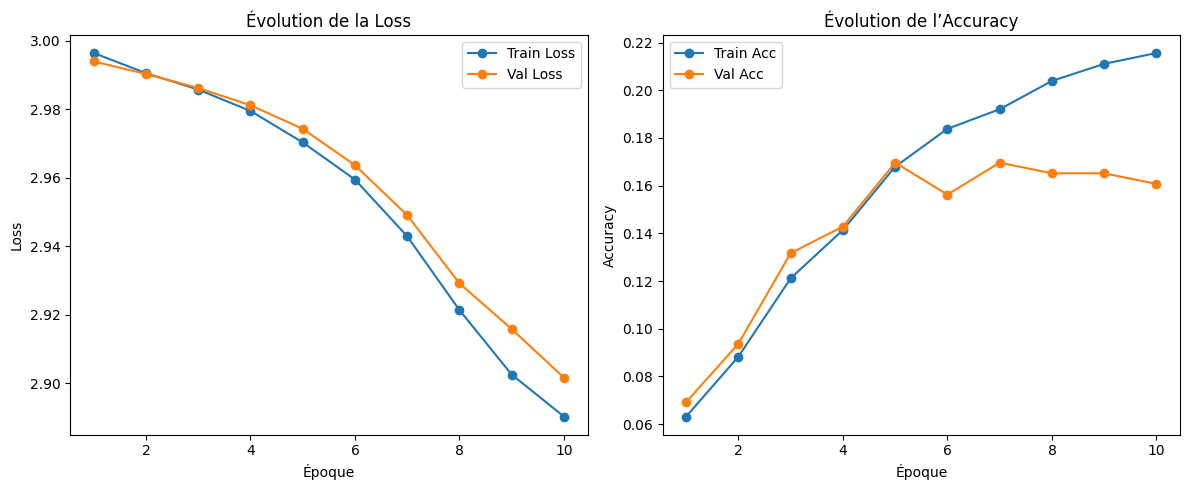


🔍 Évaluation finale sur le set de validation...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r


📋 Rapport de classification (par classe) :
              precision    recall  f1-score   support

           0      0.175     0.611     0.272        18
           1      0.000     0.000     0.000        15
           2      0.091     0.304     0.140        23
           3      0.286     0.212     0.243        66
           4      0.175     0.350     0.233        20
           5      0.333     0.083     0.133        12
           6      0.000     0.000     0.000        15
           7      0.375     0.079     0.130        38
           8      0.000     0.000     0.000        10
           9      0.444     0.186     0.262        43
          10      0.000     0.000     0.000        22
          11      0.125     0.125     0.125        16
          12      0.233     0.368     0.286        19
          13      0.128     0.200     0.156        25
          14      0.000     0.000     0.000        25
          15      0.000     0.000     0.000         7
          16      0.100     0.036    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Matrice de confusion enregistrée dans : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/confusion_matrix.png


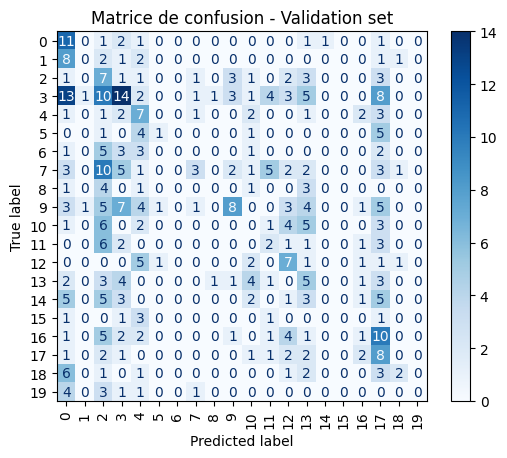


📌 RÉSUMÉ FINAL :
➡️ Meilleure époque : 5
➡️ Meilleure précision validation : 0.1696
➡️ Learning rate final : 5.00e-06
➡️ Modèle enregistré : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/best_panns_subset.pt
➡️ Courbes sauvegardées : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/training_curves.png
➡️ Matrice de confusion : /content/drive/MyDrive/Projet non-alternant/Audio/PANNs/confusion_matrix.png
➡️ Arrêt anticipé après 10 époques totales



In [ ]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# =============================
# ⚙️ CONFIGURATION
# =============================
save_dir = "/content/drive/MyDrive/Projet non-alternant/Audio/PANNs"  # 👈 ton dossier Drive
os.makedirs(save_dir, exist_ok=True)  # crée le dossier s’il n’existe pas

num_epochs = 50
best_val_acc = 0.0
best_epoch = 0
patience = 5
no_improve_epochs = 0

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"🚀 Démarrage de l'entraînement sur {num_epochs} époques...\n")

# =============================
# 🧠 ENTRAÎNEMENT
# =============================
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        if waveforms.ndim == 3:
            waveforms = torch.mean(waveforms, dim=1)

        optimizer.zero_grad()
        output_dict = model(waveforms)
        outputs = output_dict["clipwise_output"]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * waveforms.size(0)
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, total_val = 0.0, 0, 0

    with torch.no_grad():
        for waveforms, labels in val_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            if waveforms.ndim == 3:
                waveforms = torch.mean(waveforms, dim=1)
            output_dict = model(waveforms)
            outputs = output_dict["clipwise_output"]
            loss = criterion(outputs, labels)

            val_loss += loss.item() * waveforms.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\n📊 Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"🔁 Learning rate actuel : {optimizer.param_groups[0]['lr']:.2e}")

    # 💾 Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        model_path = os.path.join(save_dir, "best_panns_subset.pt")  # 👈 modifié
        torch.save(model.state_dict(), model_path)
        print(f"✅ Nouveau meilleur modèle sauvegardé : {model_path} (Val Acc = {val_acc:.4f})")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"⚠️ Aucune amélioration ({no_improve_epochs}/{patience})")

        if no_improve_epochs >= patience:
            print("⏹ Early stopping déclenché !")
            break

    scheduler.step(val_acc)

if no_improve_epochs > 0:
    print(f"↘️ Learning rate ajusté à : {optimizer.param_groups[0]['lr']:.2e}")

print(f"\n🏁 Entraînement terminé. Meilleure Val Acc : {best_val_acc:.4f} (atteinte à l’époque {best_epoch})")

# =============================
# 📈 VISUALISATION + SAUVEGARDE DES COURBES
# =============================
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Évolution de la Loss")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title("Évolution de l’Accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt_path = os.path.join(save_dir, "training_curves.png")  # 👈 sauvegarde des courbes
plt.savefig(plt_path)
print(f"🖼️ Courbes enregistrées dans : {plt_path}")
plt.show()

# =============================
# 🧪 ÉVALUATION FINALE
# =============================
print("\n🔍 Évaluation finale sur le set de validation...")

model_path = os.path.join(save_dir, "best_panns_subset.pt")  # 👈 même chemin que sauvegarde
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # 👈 mode évaluation

all_preds, all_labels = [], []

with torch.no_grad():
    for waveforms, labels in val_loader:
        waveforms = torch.mean(waveforms, dim=1).to(device)
        labels = labels.to(device)
        outputs = model(waveforms)["clipwise_output"]
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Rapport par classe
print("\n📋 Rapport de classification (par classe) :")
print(classification_report(all_labels, all_preds, digits=3))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matrice de confusion - Validation set")

cm_path = os.path.join(save_dir, "confusion_matrix.png")  # 👈 sauvegarde matrice
plt.savefig(cm_path)
print(f"📊 Matrice de confusion enregistrée dans : {cm_path}")
plt.show()

# =============================
# 🏆 RÉSUMÉ AUTOMATIQUE
# =============================
print("\n📌 RÉSUMÉ FINAL :")
print(f"➡️ Meilleure époque : {best_epoch}")
print(f"➡️ Meilleure précision validation : {best_val_acc:.4f}")
print(f"➡️ Learning rate final : {optimizer.param_groups[0]['lr']:.2e}")
print(f"➡️ Modèle enregistré : {model_path}")
print(f"➡️ Courbes sauvegardées : {plt_path}")
print(f"➡️ Matrice de confusion : {cm_path}")
print(f"➡️ Arrêt anticipé après {best_epoch + no_improve_epochs} époques totales\n")

